In [8]:
import numpy as np
import pandas as pd
import xarray as xr

In [13]:
%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
from glob import glob

In [10]:
csv_filenames = glob('/data/Houston/arm-interp-sonde/ascii-csv/houinterpolatedsondeM1.c1.*.csv')
nc_filenames = glob('/data/Houston/arm-interp-sonde/houinterpolatedsondeM1.c1.*.nc')
# nc_filenames

In [11]:
dfs = [pd.read_csv(fn) for fn in filenames]

In [6]:
df = pd.concat(dfs)

In [16]:
ds = xr.open_mfdataset(nc_filenames, combine='nested', concat_dim='time')

In [20]:
ds

<xarray.Dataset>
Dimensions:            (time: 175680, height: 332)
Coordinates:
  * time               (time) datetime64[ns] 2022-07-09T00:00:30 ... 2022-06-...
  * height             (height) float32 0.008 0.028 0.048 ... 39.51 40.01 40.51
Data variables: (12/39)
    base_time          (time) datetime64[ns] 2022-07-09 ... 2022-06-02
    time_offset        (time) datetime64[ns] dask.array<chunksize=(1440,), meta=np.ndarray>
    precip             (time) float32 dask.array<chunksize=(1440,), meta=np.ndarray>
    qc_precip          (time) int32 dask.array<chunksize=(1440,), meta=np.ndarray>
    temp               (time, height) float32 dask.array<chunksize=(1440, 332), meta=np.ndarray>
    qc_temp            (time, height) int32 dask.array<chunksize=(1440, 332), meta=np.ndarray>
    ...                 ...
    qc_rh_scaled       (time, height) int32 dask.array<chunksize=(1440, 332), meta=np.ndarray>
    aqc_rh_scaled      (time, height) int32 dask.array<chunksize=(1440, 332), meta=np.ndarray>
    vapor_source       (time, height) int32 dask.array<chunksize=(1440, 332), meta=np.ndarray>
    lat                (time) float32 29.67 29.67 29.67 ... 29.67 29.67 29.67
    lon                (time) float32 -95.06 -95.06 -95.06 ... -95.06 -95.06
    alt                (time) float32 8.0 8.0 8.0 8.0 8.0 ... 8.0 8.0 8.0 8.0
Attributes: (12/13)
    command_line:          idl -R -n interpolatedsonde -s hou -f M1 -b 202207...
    Conventions:           ARM-1.3
    process_version:       vap-interpolatedsonde-7.1-1.el7
    dod_version:           interpolatedsonde-c1-4.2
    input_datastreams:     hougriddedsondeM1.c0 : 3.2 : 20220707.000030-20220...
    site_id:               hou
    ...                    ...
    facility_id:           M1
    data_level:            c1
    location_description:  Tracking Aerosol Convection Interactions Experimen...
    datastream:            houinterpolatedsondeM1.c1
    doi:                   10.5439/1095316
    history:               created by user dsmgr on machine zinc at 2022-07-1...

In [25]:
# actually 3-hourly
ds_hourly = ds.sortby('time').resample(time='3H').mean(dim='time')

In [26]:
ds_hourly

<xarray.Dataset>
Dimensions:            (time: 976, height: 332)
Coordinates:
  * time               (time) datetime64[ns] 2022-06-01 ... 2022-09-30T21:00:00
  * height             (height) float32 0.008 0.028 0.048 ... 39.51 40.01 40.51
Data variables: (12/37)
    precip             (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    qc_precip          (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    temp               (time, height) float32 dask.array<chunksize=(1, 332), meta=np.ndarray>
    qc_temp            (time, height) float64 dask.array<chunksize=(1, 332), meta=np.ndarray>
    source_temp        (time, height) float64 dask.array<chunksize=(1, 332), meta=np.ndarray>
    rh                 (time, height) float32 dask.array<chunksize=(1, 332), meta=np.ndarray>
    ...                 ...
    qc_rh_scaled       (time, height) float64 dask.array<chunksize=(1, 332), meta=np.ndarray>
    aqc_rh_scaled      (time, height) float64 dask.array<chunksize=(1, 332), meta=np.ndarray>
    vapor_source       (time, height) float64 dask.array<chunksize=(1, 332), meta=np.ndarray>
    lat                (time) float32 29.67 29.67 29.67 ... 29.67 29.67 29.67
    lon                (time) float32 -95.06 -95.06 -95.06 ... -95.06 -95.06
    alt                (time) float32 8.0 8.0 8.0 8.0 8.0 ... 8.0 8.0 8.0 8.0

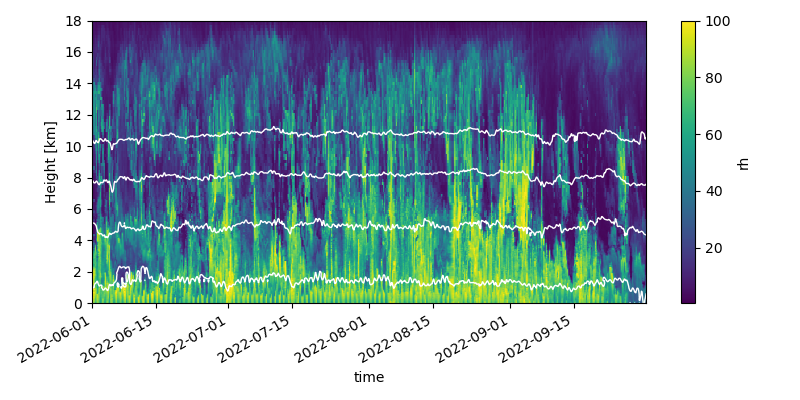

In [33]:
fig,ax=plt.subplots(1,1, figsize=(8,4))
art = ds_hourly.rh.T.plot()
ax.set_ylim(0, 18)
contour = ds_hourly.temp.T.plot.contour(levels=(20, 0, -20, -40), colors='white', linestyles='solid', linewidths=1)
art.set_rasterized(True)
fig.tight_layout()

In [34]:
fig.savefig('/Users/ebruning/Documents/Publications/TRACER-tracking-dualpol-ltg/TRACER_RH_3h_timeseries.pdf')

Calculate a representative daily value of RH in the 700-500 hPa layer

In [46]:
avg_press_hpa = ds_hourly.bar_pres.mean(dim='time').compute()*10

In [78]:
print(avg_press_hpa[77].values, avg_press_hpa[159].values, avg_press_hpa[214].values)

850.59924 700.64246 500.12317


In [62]:
mean_850_idx = 77
mean_700_idx = 159
mean_500_idx = 214

In [88]:
print(ds_hourly.height[mean_700_idx],
      ds_hourly.height[mean_500_idx])

<xarray.DataArray 'height' ()>
array(3.1879976, dtype=float32)
Coordinates:
    height   float32 3.188
Attributes:
    long_name:      Height
    units:          km
    comment:        Height represents distance above mean sea level
    standard_name:  altitude <xarray.DataArray 'height' ()>
array(5.908, dtype=float32)
Coordinates:
    height   float32 5.908
Attributes:
    long_name:      Height
    units:          km
    comment:        Height represents distance above mean sea level
    standard_name:  altitude


In [91]:
rh_700_hPa = ds_hourly.rh[:,mean_700_idx].compute()

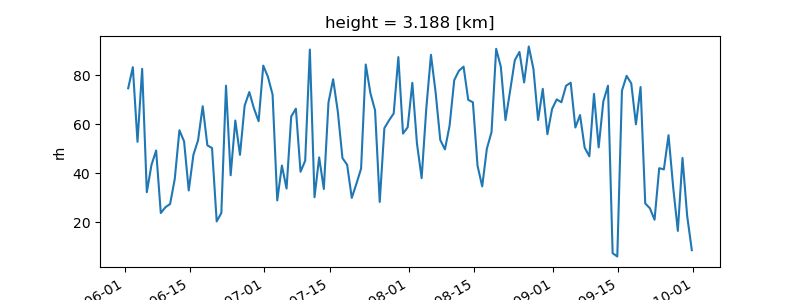

In [92]:
time_18Z_slice = slice(6, None, 8)
fig,ax=plt.subplots(1,1, figsize=(8,3))
rh_700_hPa[time_18Z_slice].plot()
rh_700_hPa[time_18Z_slice].to_dataframe().to_csv('/Users/ebruning/Documents/Publications/TRACER-tracking-dualpol-ltg/arm_rh_700.csv')

In [69]:
avg_lower_free_trop_rh = ds_hourly.rh[:,mean_700_idx:mean_500_idx].mean(dim='height').compute()

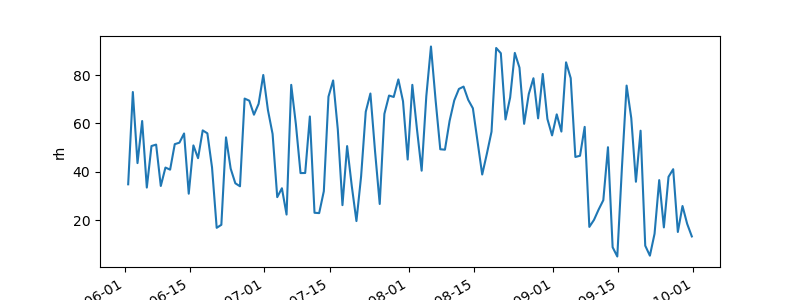

In [93]:
time_18Z_slice = slice(6, None, 8)
fig,ax=plt.subplots(1,1, figsize=(8,3))
avg_lower_free_trop_rh[time_18Z_slice].plot()
avg_lower_free_trop_rh[time_18Z_slice].to_dataframe().to_csv('/Users/ebruning/Documents/Publications/TRACER-tracking-dualpol-ltg/arm_rh_700_500.csv')

In [82]:
ds_hourly.time[time_18Z_slice]

<xarray.DataArray 'time' (time: 122)>
array(['2022-06-01T18:00:00.000000000', '2022-06-02T18:00:00.000000000',
       '2022-06-03T18:00:00.000000000', '2022-06-04T18:00:00.000000000',
       '2022-06-05T18:00:00.000000000', '2022-06-06T18:00:00.000000000',
       '2022-06-07T18:00:00.000000000', '2022-06-08T18:00:00.000000000',
       '2022-06-09T18:00:00.000000000', '2022-06-10T18:00:00.000000000',
       '2022-06-11T18:00:00.000000000', '2022-06-12T18:00:00.000000000',
       '2022-06-13T18:00:00.000000000', '2022-06-14T18:00:00.000000000',
       '2022-06-15T18:00:00.000000000', '2022-06-16T18:00:00.000000000',
       '2022-06-17T18:00:00.000000000', '2022-06-18T18:00:00.000000000',
       '2022-06-19T18:00:00.000000000', '2022-06-20T18:00:00.000000000',
       '2022-06-21T18:00:00.000000000', '2022-06-22T18:00:00.000000000',
       '2022-06-23T18:00:00.000000000', '2022-06-24T18:00:00.000000000',
       '2022-06-25T18:00:00.000000000', '2022-06-26T18:00:00.000000000',
       '2022-06-27T18:00:00.000000000', '2022-06-28T18:00:00.000000000',
       '2022-06-29T18:00:00.000000000', '2022-06-30T18:00:00.000000000',
       '2022-07-01T18:00:00.000000000', '2022-07-02T18:00:00.000000000',
       '2022-07-03T18:00:00.000000000', '2022-07-04T18:00:00.000000000',
       '2022-07-05T18:00:00.000000000', '2022-07-06T18:00:00.000000000',
       '2022-07-07T18:00:00.000000000', '2022-07-08T18:00:00.000000000',
       '2022-07-09T18:00:00.000000000', '2022-07-10T18:00:00.000000000',
       '2022-07-11T18:00:00.000000000', '2022-07-12T18:00:00.000000000',
       '2022-07-13T18:00:00.000000000', '2022-07-14T18:00:00.000000000',
       '2022-07-15T18:00:00.000000000', '2022-07-16T18:00:00.000000000',
       '2022-07-17T18:00:00.000000000', '2022-07-18T18:00:00.000000000',
       '2022-07-19T18:00:00.000000000', '2022-07-20T18:00:00.000000000',
       '2022-07-21T18:00:00.000000000', '2022-07-22T18:00:00.000000000',
       '2022-07-23T18:00:00.000000000', '2022-07-24T18:00:00.000000000',
       '2022-07-25T18:00:00.000000000', '2022-07-26T18:00:00.000000000',
       '2022-07-27T18:00:00.000000000', '2022-07-28T18:00:00.000000000',
       '2022-07-29T18:00:00.000000000', '2022-07-30T18:00:00.000000000',
       '2022-07-31T18:00:00.000000000', '2022-08-01T18:00:00.000000000',
       '2022-08-02T18:00:00.000000000', '2022-08-03T18:00:00.000000000',
       '2022-08-04T18:00:00.000000000', '2022-08-05T18:00:00.000000000',
       '2022-08-06T18:00:00.000000000', '2022-08-07T18:00:00.000000000',
       '2022-08-08T18:00:00.000000000', '2022-08-09T18:00:00.000000000',
       '2022-08-10T18:00:00.000000000', '2022-08-11T18:00:00.000000000',
       '2022-08-12T18:00:00.000000000', '2022-08-13T18:00:00.000000000',
       '2022-08-14T18:00:00.000000000', '2022-08-15T18:00:00.000000000',
       '2022-08-16T18:00:00.000000000', '2022-08-17T18:00:00.000000000',
       '2022-08-18T18:00:00.000000000', '2022-08-19T18:00:00.000000000',
       '2022-08-20T18:00:00.000000000', '2022-08-21T18:00:00.000000000',
       '2022-08-22T18:00:00.000000000', '2022-08-23T18:00:00.000000000',
       '2022-08-24T18:00:00.000000000', '2022-08-25T18:00:00.000000000',
       '2022-08-26T18:00:00.000000000', '2022-08-27T18:00:00.000000000',
       '2022-08-28T18:00:00.000000000', '2022-08-29T18:00:00.000000000',
       '2022-08-30T18:00:00.000000000', '2022-08-31T18:00:00.000000000',
       '2022-09-01T18:00:00.000000000', '2022-09-02T18:00:00.000000000',
       '2022-09-03T18:00:00.000000000', '2022-09-04T18:00:00.000000000',
       '2022-09-05T18:00:00.000000000', '2022-09-06T18:00:00.000000000',
       '2022-09-07T18:00:00.000000000', '2022-09-08T18:00:00.000000000',
       '2022-09-09T18:00:00.000000000', '2022-09-10T18:00:00.000000000',
       '2022-09-11T18:00:00.000000000', '2022-09-12T18:00:00.000000000',
       '2022-09-13T18:00:00.000000000', '2022-09-14T18:00:00.000000000',
       '2022-09-15T18:00:00.000000000', '2022-09-16T18:00:00.000000000',
       '2022-09-17T1